In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from pyrcn.echo_state_network import ESNRegressor

structural_mask = pd.read_csv('data/sub-CON01_ses-preop.csv',header=None)
structural_mask = (structural_mask > 0).astype(int)
# sns.heatmap(structural_mask)

In [2]:
df = pd.read_csv('data/sub-CON01_ses-preop_task-rest_space-MNI152NLin2009cAsym_atlas-Gordon_desc-timeseries_bold.tsv', header=None)
df = df.T

# Finding out the right number of params for a random pair or regions for single person

In [3]:
x = df.iloc[111]
y = df.iloc[222]
x = x.values.reshape(-1,1)
y = y.values.reshape(-1,1)

In [4]:
train_len = int(len(x) * 0.6)

X_train = np.array(x[:train_len]).reshape(-1, 1)
X_test = np.array(x[train_len:]).reshape(-1, 1)
y_train = np.array(y[:train_len])
y_test = np.array(y[train_len:])

In [5]:
print("params  train   test")
for reservoir_size in [3, 5, 10, 15, 20, 25, 30, 35, 40, 60, 100, 200, 300, 400]:
    reg = ESNRegressor(hidden_layer_size=reservoir_size)
    reg.fit(X=X_train, y=y_train)

    y_pred = reg.predict(X_test)
    test_corr = np.corrcoef(y_test.reshape(-1), y_pred.reshape(-1))[0, 1]

    y_pred_train = reg.predict(X_train)
    train_corr = np.corrcoef(y_train.reshape(-1), y_pred_train.reshape(-1))[0, 1]
    print(f"{reservoir_size:6} {train_corr:6.2f} {test_corr:6.2f}")

params  train   test
     3   0.40   0.31
     5   0.45   0.30
    10   0.49   0.23
    15   0.57   0.31
    20   0.62   0.36
    25   0.61   0.32
    30   0.68   0.26
    35   0.71   0.11
    40   0.71   0.31
    60   0.79   0.23
   100   0.98  -0.01
   200   1.00   0.29
   300   1.00   0.21
   400   1.00   0.27


In [6]:
np.corrcoef(y_test.reshape(-1), X_test.reshape(-1))[0, 1]

0.3002823402066563

# Finding causality between each pair of regions

In [9]:
num_of_regions = df.shape[0]
train_len = int(df.shape[1] * 0.6)

causality_matrix = np.zeros((num_of_regions, num_of_regions))

for i in range(num_of_regions):
    for j in range(num_of_regions):
        if i == j:
            causality_matrix[i, j] = 0
            continue
        # if structural_mask[i][j] == 0:
        x = df.iloc[i]
        y = df.iloc[j]
        x = x.values.reshape(-1,1)
        y = y.values.reshape(-1,1)

        X_train = np.array(x[:train_len]).reshape(-1, 1)
        X_test = np.array(x[train_len:]).reshape(-1, 1)
        y_train = np.array(y[:train_len])
        y_test = np.array(y[train_len:])

        reg = ESNRegressor(hidden_layer_size=20)
        reg.fit(X=X_train, y=y_train)

        y_pred = reg.predict(X_test)
        test_corr = np.corrcoef(y_test.reshape(-1), y_pred.reshape(-1))[0, 1]
        causality_matrix[i][j] = test_corr

        # print(f"{i:3} {j:3} {test_corr:6.2f}")

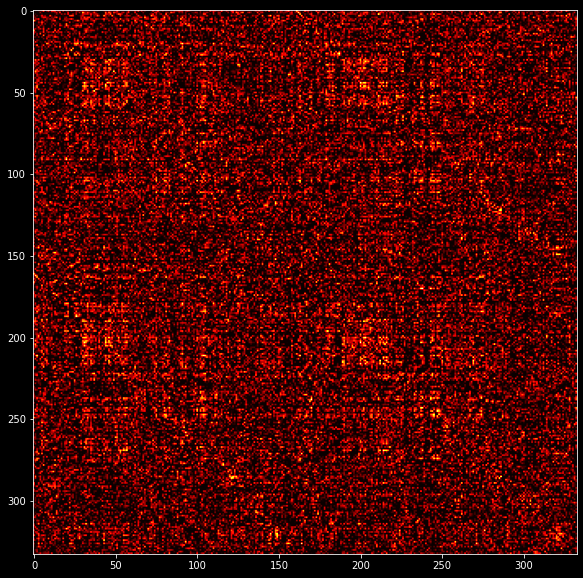

In [56]:
# display thresholded causality matrix
plt.figure(figsize=(10, 10))

# apply threshold
thresholded_matrix = causality_matrix.copy()
thresholded_matrix[thresholded_matrix < 0.0] = 0

plt.imshow(thresholded_matrix, cmap='hot')

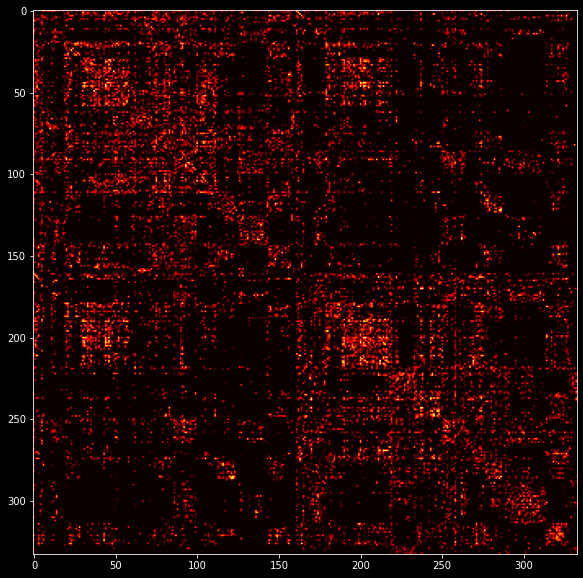

In [57]:
plt.figure(figsize=(10, 10))
effective_matrix = structural_mask * thresholded_matrix
plt.imshow(effective_matrix, cmap='hot')
# plt.imshow(structural_mask, cmap='hot')

In [58]:
dmn_regions = [
    1,
    4,
    6,
    25,
    26,
    44,
    94,
    114,
    116,
    117,
    126,
    127,
    145,
    146,
    150,
    151,
    152,
    154,
    156,
    157,
    162,
    165,
    184,
    186,
    200,
    220,
    225,
    257,
    259,
    278,
    279,
    290,
    315,
    316,
    321,
    322,
    323,
    324,
    325,
    326,
]

In [59]:
dmn_causalities = []
for i in dmn_regions:
    for j in dmn_regions:
        if i == j:
            continue
        dmn_causalities.append(effective_matrix[i][j])

In [60]:
np.count_nonzero(dmn_causalities) / len(dmn_causalities)

0.20897435897435898

In [61]:
np.average(structural_mask)

0.28213799384970556